In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import time

Seam Carve

In [2]:
class SeamEnergyWithBackPointer:
    def __init__(self, energy, coordinate_in_previous_step=None):
        self.energy = energy
        self.coordinate_in_previous_step = coordinate_in_previous_step

def min_vertical_seam_energy(pixel_energies):
    seam_energies = []
    seam_energies.append([SeamEnergyWithBackPointer(pixel_energy) for pixel_energy in pixel_energies[0]])

    for y in range(1, len(pixel_energies)):
        pixel_energies_row = pixel_energies[y]
        seam_energies_row = []
            
        for x, pixel_energy in enumerate(pixel_energies_row):
            x_left = max(x - 1, 0)
            x_right = min(x + 1, len(pixel_energies_row) - 1)
            x_range = range(x_left, x_right + 1)
                
            min_parent_x = min(x_range, key=lambda x_i: seam_energies[y - 1][x_i].energy)
                
            min_seam_energy = SeamEnergyWithBackPointer(
                pixel_energy + seam_energies[y - 1][min_parent_x].energy,
                min_parent_x
            )

            seam_energies_row.append(min_seam_energy)
            
        seam_energies.append(seam_energies_row)
        
    min_energy = min(seam_energies[-1], key=lambda x: x.energy).energy
    return min_energy

def find_vertical_seam(pixel_energies):
    seam_energies = []
    seam_energies.append([SeamEnergyWithBackPointer(pixel_energy) for pixel_energy in pixel_energies[0]])
        
    for y in range(1, len(pixel_energies)):
        pixel_energies_row = pixel_energies[y]
        seam_energies_row = []
            
        for x, pixel_energy in enumerate(pixel_energies_row):
            x_left = max(x - 1, 0)
            x_right = min(x + 1, len(pixel_energies_row) - 1)
            x_range = range(x_left, x_right + 1)
                
            min_parent_x = min(x_range, key=lambda x_i: seam_energies[y - 1][x_i].energy)
                
            min_seam_energy = SeamEnergyWithBackPointer(
                pixel_energy + seam_energies[y - 1][min_parent_x].energy,
                min_parent_x
            )
                
            seam_energies_row.append(min_seam_energy)
            
        seam_energies.append(seam_energies_row)
        
    min_seam_end_x = min(range(len(seam_energies[-1])), key=lambda x: seam_energies[-1][x].energy)
        
    seam = []
    seam_point_x = min_seam_end_x
    for y in range(len(seam_energies) - 1, -1, -1):
        seam.append((seam_point_x, y))
        seam_point_x = seam_energies[y][seam_point_x].coordinate_in_previous_step
        
    seam.reverse()
    return seam

def min_horizontal_seam_energy(pixel_energies):
    pixel_energies = np.rot90(pixel_energies, k=-1)
    return min_vertical_seam_energy(pixel_energies)

def find_horizontal_seam(pixel_energies):
    pixel_energies = np.rot90(pixel_energies, k=-1)
    return find_vertical_seam(pixel_energies)

In [3]:
# Perform seam carving
def carve_seam(magnitude, phase, seam_path):
    new_magnitude = []
    new_phase = []
    # Remove pixels along the seam path for vertical seams
    for y in range(len(magnitude)):
        new_row_magnitude = []
        new_row_phase = []
        seam_indices = set([x for x, _ in seam_path if _ == y])

        for x in range(len(magnitude[y])):
            if x not in seam_indices:
                new_row_magnitude.append(magnitude[y][x])
                new_row_phase.append(phase[y][x])

        new_magnitude.append(new_row_magnitude)
        new_phase.append(new_row_phase)
    return np.array(new_magnitude), np.array(new_phase)

In [6]:
def carve_audio(n_of_seams, magnitude, phase, is_vertical=True):
    if is_vertical:
        for i in range(n_of_seams):
            seam_path = find_vertical_seam(magnitude)
            magnitude, phase = carve_seam(magnitude, phase, seam_path)
    else:
        magnitude = np.rot90(magnitude, k=-1)
        phase = np.rot90(phase, k=-1)
        for i in range(n_of_seams):
            seam_path = find_vertical_seam(magnitude)
            magnitude, phase = carve_seam(magnitude, phase, seam_path)
        magnitude = np.rot90(magnitude, k=1)
        phase = np.rot90(phase, k=1)
    return magnitude, phase
        
# Write the final edited matrix to a text file for further use
# with open('final_output_matrix.txt', 'w') as f:
#     for row in magnitude:
#         f.write(' '.join(map(str, row)) + '\n')

work below

In [10]:
# Load in sounds
NJ, srNJ = librosa.load('NewJeansOMG.wav', sr=None, mono=True)
print(srNJ, "sr_flute sampling rate")

44100 sr_flute sampling rate


In [11]:
D = librosa.stft(NJ)
magnitudeNJ = np.abs(D)
phaseNJ = np.angle(D)
magnitudeNJ = np.array(magnitudeNJ)
phaseNJ = np.array(phaseNJ)
print("shape of magnitude before", magnitudeNJ.shape)
print("shape of phase before", phaseNJ.shape)

shape of magnitude before (1025, 1332)
shape of phase before (1025, 1332)


In [12]:
n_of_seams = 500
start = time.time()
magnitude, phase = carve_audio(n_of_seams, magnitudeNJ, phaseNJ, is_vertical=True)

print("shape of magnitude after", magnitude.shape)
print("shape of phase after", phase.shape)

KeyboardInterrupt: 

In [247]:
# Reconstruct the complex spectrogram
complex_spectrogram = magnitude * np.exp(1j * phase)

reconstructed_signal = librosa.istft(complex_spectrogram)

output_filename = f'NewJeansOMG_vertical{n_of_seams}.wav'

# Write the reconstructed audio signal to a file using soundfile
sf.write(output_filename, reconstructed_signal, srNJ)

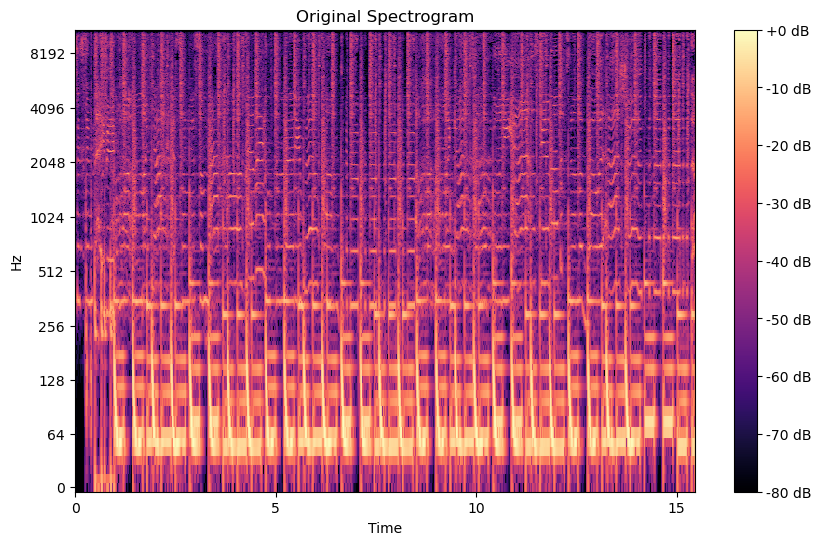

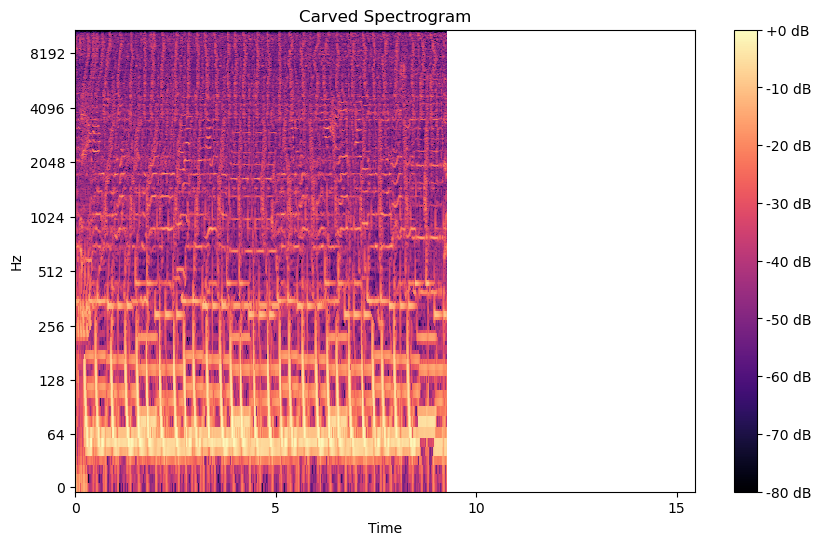

In [240]:
# Calculate spectrogram for original data
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_flute, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()

plt.show()

# new_flute, sr_f = librosa.load('Flute_CarvedSeams80.wav')
# D = librosa.stft(new_flute)
# # Magnitude and phase
# magnitude = np.abs(D)
# phase = np.angle(D)
# complex_spectrogram = magnitude * np.exp(1j * phase)

# Calculate spectrogram for complex spectrogram data
D_db = librosa.amplitude_to_db(np.abs(complex_spectrogram), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=srNJ, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Carved Spectrogram')

# Set the same axis limits as the first plot
plt.axis([xmin, xmax, ymin, ymax])

plt.show()

horizontal

In [5]:
NJ, srNJ = librosa.load('NewJeansOMG.wav', sr=None, mono=False)
D = librosa.stft(NJ)
magnitudeNJ = np.abs(D)
phaseNJ = np.angle(D)
magnitudeNJ = np.array(magnitudeNJ)
phaseNJ = np.array(phaseNJ)
print("shape of magnitude before", magnitudeNJ.shape)
print("shape of phase before", phaseNJ.shape)
print(srNJ)
print(D.shape)

shape of magnitude before (2, 1025, 1332)
shape of phase before (2, 1025, 1332)
44100
(2, 1025, 1332)


In [249]:
# DONT RUN UNLESS YOU WANT TO DO THE CARVING
n_of_seams = 525
start = time.time()
magnitude1, phase1 = carve_audio(n_of_seams, magnitudeNJ, phaseNJ, is_vertical=False)
end = time.time()
print("shape of magnitude after", magnitude1.shape)
print("shape of phase after", phase1.shape)
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

shape of magnitude after (500, 1332)
shape of phase after (500, 1332)
The time of execution of above program is : 616942.0900344849 ms


In [256]:
# Reconstruct the complex spectrogram
complex_spectrogram1 = magnitude1 * np.exp(1j * phase1)

reconstructed_signal1 = librosa.istft(complex_spectrogram1) #ISSUE HERE CHANGES TO MONO

output_filename = f'NewJeansOMG_horizontal{n_of_seams}.wav'

# Write the reconstructed audio signal to a file using soundfile
#sf.write(output_filename, reconstructed_signal1, srNJ)
print(complex_spectrogram1.shape)
print(reconstructed_signal1.shape)

(500, 1332)
(331419,)


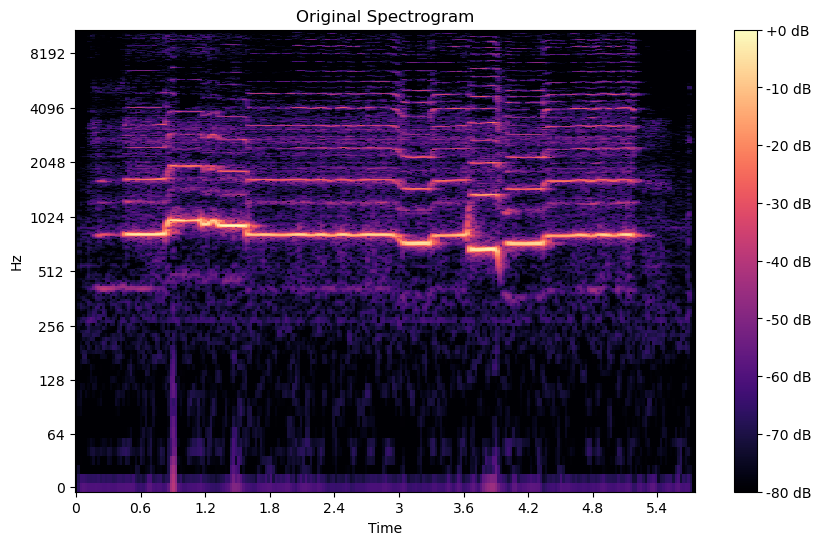

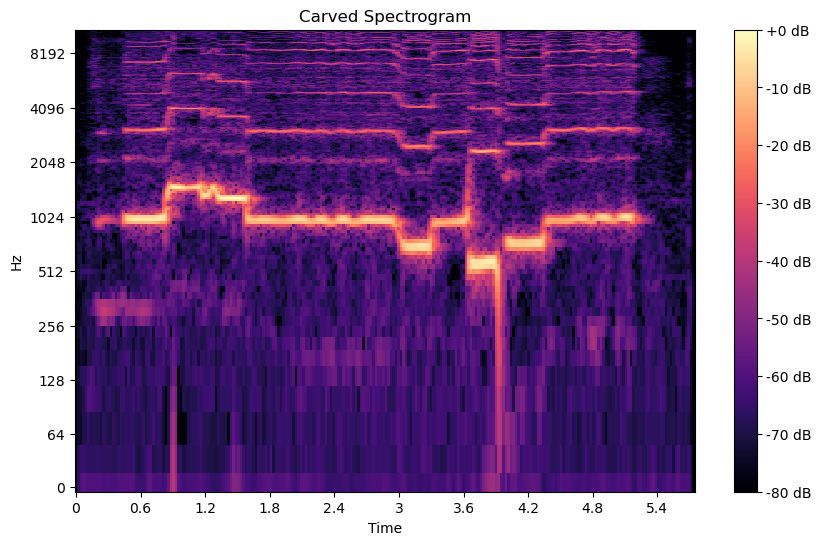

In [218]:
# Calculate spectrogram for original data
D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_flute, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Get axis limits of the first plot
xmin, xmax, ymin, ymax = plt.axis()

plt.show()

# new_flute, sr_f = librosa.load('frequencyflute400.wav')
# D = librosa.stft(new_flute)
# # Magnitude and phase
# magnitude = np.abs(D)
# phase = np.angle(D)
#complex_spectrogram = magnitude * np.exp(1j * phase)

# Calculate spectrogram for complex spectrogram data
D_db = librosa.amplitude_to_db(np.abs(complex_spectrogram1), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr_f, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Carved Spectrogram')

# Set the same axis limits as the first plot
plt.axis([xmin, xmax, ymin, ymax])

plt.show()

In [216]:
m = np.array([[1, 4, 6], [4, 8, 9], [3, 2, 5]])
print(m)
print()
# print(np.rot90(m, k=-1))
p = np.array([[1, 4, 6], [4, 8, 9], [3, 2, 5]])
print(p)
# seam_path = find_horizontal_seam(m)
# print()
# print(seam_path)
# print()
# m, p = carve_seam(m, p, seam_path, is_vertical=True)
# print(m)
# print()
# print(np.rot90(m, k=1))
n_of_seams = 1
m, p = carve_audio(n_of_seams, m, p, is_vertical=False)
print()
print(m)
print()
print(p)
print()
m, p = carve_audio(n_of_seams, m, p, is_vertical=True)
print()
print(m)
print()
print(p)

[[1 4 6]
 [4 8 9]
 [3 2 5]]

[[1 4 6]
 [4 8 9]
 [3 2 5]]

[[1 4 6]
 [4 8 9]]

[[1 4 6]
 [4 8 9]]


[[4 6]
 [8 9]]

[[4 6]
 [8 9]]
